# Imports 

In [1]:
!pip install minisom

  Preparing metadata (setup.py) ... - \ done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=df780668d1895644afcb40bc154ac84c54f6e1a1231dc1239630e25c3fea3a8e
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from minisom import MiniSom
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Reading and Exploring the data

In [3]:
train_data = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
train_data = train_data.drop('CustomerID', axis=1)

train_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [4]:
print('train_data rows: ',train_data.shape[0])
print('train_data columns: ',train_data.shape[1])

train_data rows:  200
train_data columns:  4


Checking if there is **any missing values.**

In [5]:
train_missing_values = train_data.isnull().sum()
num_columns_with_train_missing_values = (train_missing_values > 0).sum()
print(f'Total number of columns with missing values: {num_columns_with_train_missing_values}')

Total number of columns with missing values: 0


Checking **datatypes** of our features

In [6]:
print("Data Types:")
print(train_data.dtypes)

Data Types:
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


Checking ther **number of unqiue values** for each feature

In [7]:
unique_values_per_column = train_data.nunique()
sorted_unique_values = unique_values_per_column.sort_values(ascending=False)

print(f"{sorted_unique_values} unique values")

Spending Score (1-100)    84
Annual Income (k$)        64
Age                       51
Gender                     2
dtype: int64 unique values


Plotting **Gender** attributes.

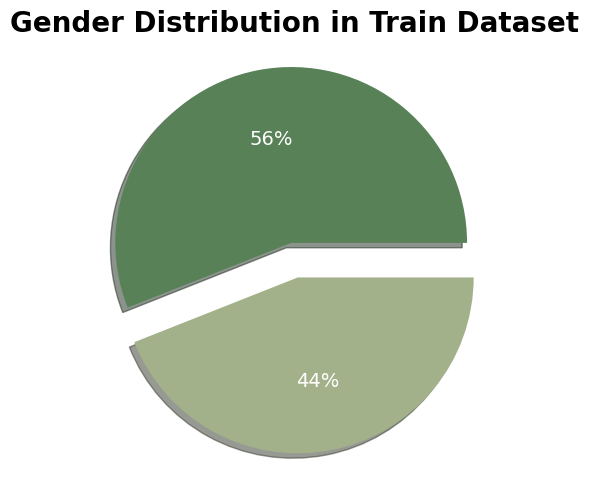

In [8]:
import matplotlib.pyplot as plt

colors = ['#588157', '#a3b18a']  # Dark green and olive green
gender_counts = train_data['Gender'].value_counts()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.pie(
    gender_counts, 
    labels=gender_counts.index,
    shadow=True, 
    explode=[.1 for i in range(gender_counts.nunique())],  # Adjust the explode based on the number of unique values
    autopct='%1.f%%',
    colors=colors,  # Specify the colors here
    textprops={'size': 14, 'color': 'white'}
)

ax.set_title('Gender Distribution in Train Dataset', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()


💡 More males than females

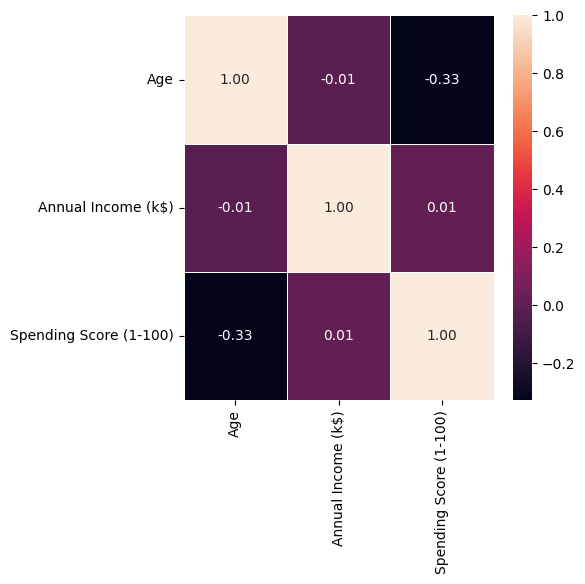

In [9]:
selected_features = [
    'Age','Annual Income (k$)','Spending Score (1-100)'
]

subset_correlation_matrix = train_data[selected_features].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(
    subset_correlation_matrix,
    annot=True,
    fmt=".2f",
    linewidths=.5
)

plt.show()

💡 Values are neither below -0.5 or above 0.5 which falls within acceptable range and there is nothing concerning.

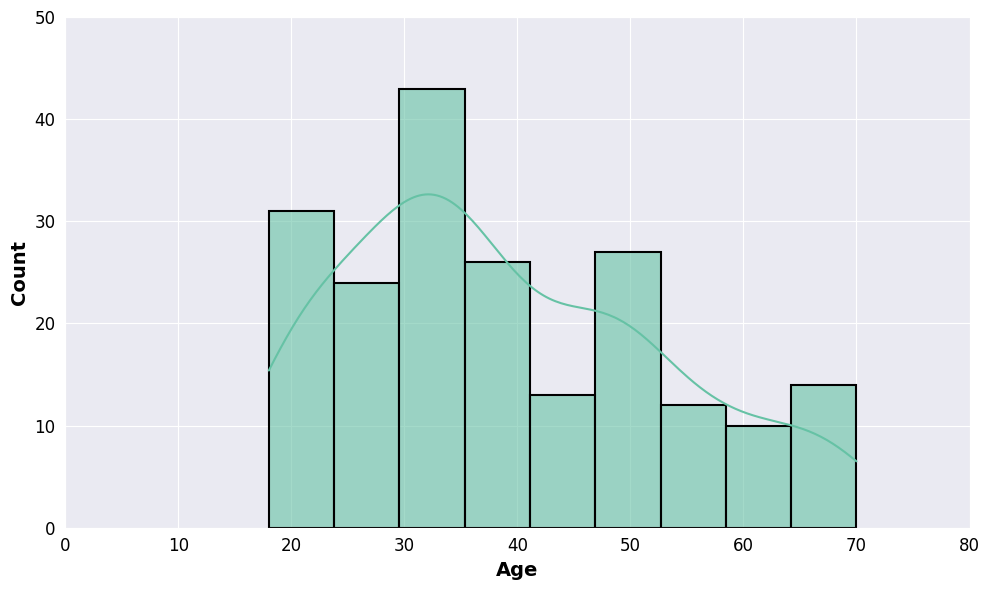

In [10]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

columns_to_plot = ['Age']

for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_data, x=column, multiple="stack", kde=True, alpha=0.6, linewidth=1.5, edgecolor='black')
    plt.xlabel('Age', fontsize=14, fontweight='bold', color='black')
    plt.ylabel('Count', fontsize=14, fontweight='bold', color='black')
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    plt.xlim(0, 80)
    plt.ylim(0, 50)
    plt.tight_layout()
    plt.show()

💡 The majority of the population are in the age range from 30-35

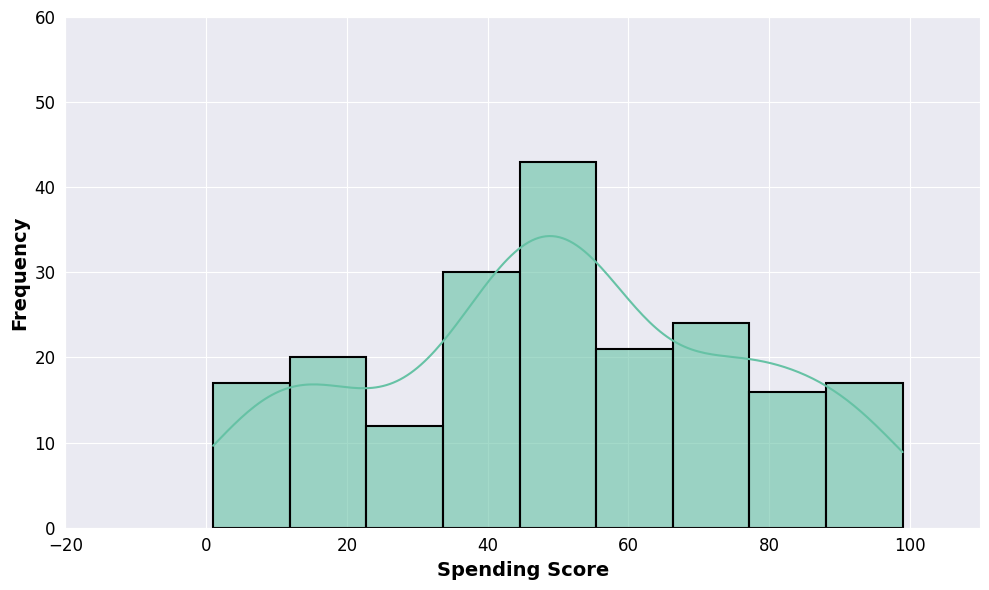

In [11]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

plt.figure(figsize=(10, 6))

sns.histplot(train_data['Spending Score (1-100)'], kde=True, alpha=0.6, linewidth=1.5, edgecolor='black')

plt.xlabel('Spending Score', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='black')

plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.xlim(-20, 110)
plt.ylim(0, 60)
plt.tight_layout()
plt.show()

💡 Spending score is at peak at 40-60

# Pre-processing

**Encoding** categorical features

In [12]:
label_encoder = LabelEncoder()
train_data['Gender'] = label_encoder.fit_transform(train_data['Gender'])

**Scaling** numeric features

In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data)

# Clustering

## K-means

Searching for the best number of clusters, I will run k=3, k=4... **to k = 21** and **compare the results using SSE, WCSS and DB**.

**Sum of Squared Errors (SSE):** represents the sum of the squared distances between each data point and its assigned cluster centroid

**Within-Cluster Sum of Squares (WCSS):** represents the sum of squared distances of each data point within its assigned cluster

**Davies Bouldin (DB):** a measure of
 uniqueness of the clusters and takes into consideration both **cohesiveness** of
 the cluster (distance between the data points and center of the cluster) **and
 separation between the clusters**.

In [14]:
# Initialize K-Means with different parameter values for k=3 to k=20
kmeans_params = [{'n_clusters': k, 'random_state': 42} for k in range(3, 21)]

# Perform K-Means clustering with different parameter values
kmeans_results = []
for params in kmeans_params:
    kmeans = KMeans(**params)
    train_data['KMeans_Cluster'] = kmeans.fit_predict(scaled_data)
    kmeans_results.append(train_data['KMeans_Cluster'].value_counts())

# Print and visualize the results
for i, result in enumerate(kmeans_results):
    print(f"K-Means Clustering Result {i+1}:\n{result}\n")

K-Means Clustering Result 1:
KMeans_Cluster
0    85
1    66
2    49
Name: count, dtype: int64

K-Means Clustering Result 2:
KMeans_Cluster
1    57
2    55
0    48
3    40
Name: count, dtype: int64

K-Means Clustering Result 3:
KMeans_Cluster
0    55
2    43
1    40
3    31
4    31
Name: count, dtype: int64

K-Means Clustering Result 4:
KMeans_Cluster
3    41
4    38
1    37
2    35
0    26
5    23
Name: count, dtype: int64

K-Means Clustering Result 5:
KMeans_Cluster
6    40
2    37
0    33
4    26
3    24
1    22
5    18
Name: count, dtype: int64

K-Means Clustering Result 6:
KMeans_Cluster
5    36
6    34
0    27
2    24
1    22
3    20
4    19
7    18
Name: count, dtype: int64

K-Means Clustering Result 7:
KMeans_Cluster
5    33
1    30
2    26
4    25
8    21
6    19
7    18
0    15
3    13
Name: count, dtype: int64

K-Means Clustering Result 8:
KMeans_Cluster
2    26
3    26
7    24
4    24
1    21
0    19
6    18
9    14
5    14
8    14
Name: count, dtype: int64

K-Means Clusteri

# Evaluation

In [15]:
import plotly.graph_objs as go
import plotly.subplots as ps
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import cdist

k_values = list(range(1, 21))  # Convert range to list

# Initialize empty lists to store WCSS, SSE, and DB index values for each k
wcss_values = []
sse_values = []
db_values = []

# Iterate over each k value and perform K-Means clustering
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    labels = kmeans.labels_
    
    # Calculate WCSS
    wcss_values.append(kmeans.inertia_)
    
    # Calculate SSE
    sse = sum(np.min(cdist(train_data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / train_data.shape[0]
    sse_values.append(sse)
    
    # Check if there are at least two unique labels for DB index calculation
    if len(set(labels)) < 2:
        print(f"Skipping k={k} due to insufficient unique labels.")
        continue
    
    # Calculate DB index
    db_index = davies_bouldin_score(train_data, labels)
    db_values.append(db_index)

# Create three 3D scatter plots
fig = ps.make_subplots(rows=3, cols=1, subplot_titles=("WCSS", "SSE", "DB Index"))

# Add traces for WCSS, SSE, and DB index
fig.add_trace(go.Scatter(x=k_values, y=wcss_values, mode='lines+markers', name='WCSS'), row=1, col=1)
fig.add_trace(go.Scatter(x=k_values, y=sse_values, mode='lines+markers', name='SSE'), row=2, col=1)
fig.add_trace(go.Scatter(x=k_values[:len(db_values)], y=db_values, mode='lines+markers', name='DB Index'), row=3, col=1)

# Update layout
fig.update_layout(height=1300, width=1200, title_text="Elbow Plots for K-Means Clustering",
                  scene=dict(xaxis_title='Number of Clusters (k)', yaxis_title='Metric Value', zaxis_title='Metric Value'))

# Show the plot
fig.show()


Skipping k=1 due to insufficient unique labels.


💡 Looking at DB, WCSS, and SSE, I decided **k = 7** is the best number of clusters for this dataset.

**Conclusion**

Even though k-means clustering is simple and easy to implement, **one of the key drawbacks** is that it seeks to find a **local optimum**, which may not yield globally optimal clustering. In this approach, the algorithm starts with an initial configuration (centroids) and continuously improves to find the best solution possible for that initial configuration. Since the solution is optimal to the initial configuration (locally optimal), there might be a better optimal solution if the initial configuration changes. The locally optimal solution may not be the most optimal solution for the given clustering problem. Hence, the success of a k-means algorithm much depends on the initiation of centroids.

**Evaluation** 

It must be noted that, in clustering, the evaluation is different from regression and classification **(supervised learning)** where labels are predefined. Here **in clustering**, we are trying to find meaningful groups in data, and **there are no labels** or ground truth to check to see the 'accuracy'.
The evaluation parameter will have to be developed from the
 very dataset that is being evaluated. This is called **unsupervised or internal
 evaluation**. 

**Interpreting SSE and Davies Bouldin Index:**

Good models will have **low SSE within the cluster and low overall SSE among all clusters.** The lower the value of the Davies-Bouldin index, the better the clustering. However, both SSE and the Davies-Bouldin index have the limitation of not guaranteeing better clustering when they have lower scores.

# K-Means Clustering with k= 7, 3D scatterplot.

In [16]:
import plotly.graph_objs as go
import plotly.express as px
from sklearn.cluster import KMeans

def kmeans_plotter(train_data, k=7):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)

    # Add cluster labels to the dataframe
    train_data['label'] = kmeans.labels_

    # Create a 3D scatter plot with the clustered data
    fig = px.scatter_3d(train_data, x='Annual Income (k$)', y='Spending Score (1-100)', z='Age', color='label',
                         symbol='label', symbol_map={0: 'circle', 1: 'circle', 2: 'circle', 3: 'circle', 4: 'circle', 5: 'circle'},
                         opacity=0.7, width=900, height=850,
                         title=f'K-Means Clustering with k={k}',
                         labels={'label': 'Cluster'},
                         color_discrete_map={})  # Remove color legend

    fig.update_layout(showlegend=False)  # Remove color legend
    return fig

# Assuming 'train_data' is your DataFrame containing the data

# Call the function to create the K-Means clustering plot
fig = kmeans_plotter(train_data)
fig.show()
